# Projet Analyse de Données : Stratège virtuel de Formule 1

<b>Ce projet porte sur l'étude et l'analyse des résultats et de données de toutes les courses de Formule 1 qui se sont déroulées de 1950 à 2018.</b><br><br>
En Formule 1, de nombreux facteurs sont clés dans la route vers la victoire d'un Grand Prix. On retrouve entre autres : 
<ul>
    <li>La performance de la voiture</li>
    <li>Le talent du pilote</li>
    <li>La position sur la grille (déterminée par une séance de qualification)</li>
    <li>La gestion de l'essence</li>
    <li>La gestion de l'usure des pneus et l'utilisation astucieuse d'arrêts au stand</li>
    <li>La réactivité aux évènements de course comme la tombée de pluie, les accidents sur piste...</li>
</ul>

Dans ce projet, nous allons: 

<ul>
    <li>1. tenter de prédire la position à l'arrivée d'un pilote  </li>
    <li>2. essayer de déterminer à quel moment de la course un pilote a réalisé un arrêt au stand</li>
    <li>3. le type de pneus utilsé dans chaque tour</li>

</ul>
<br><br>


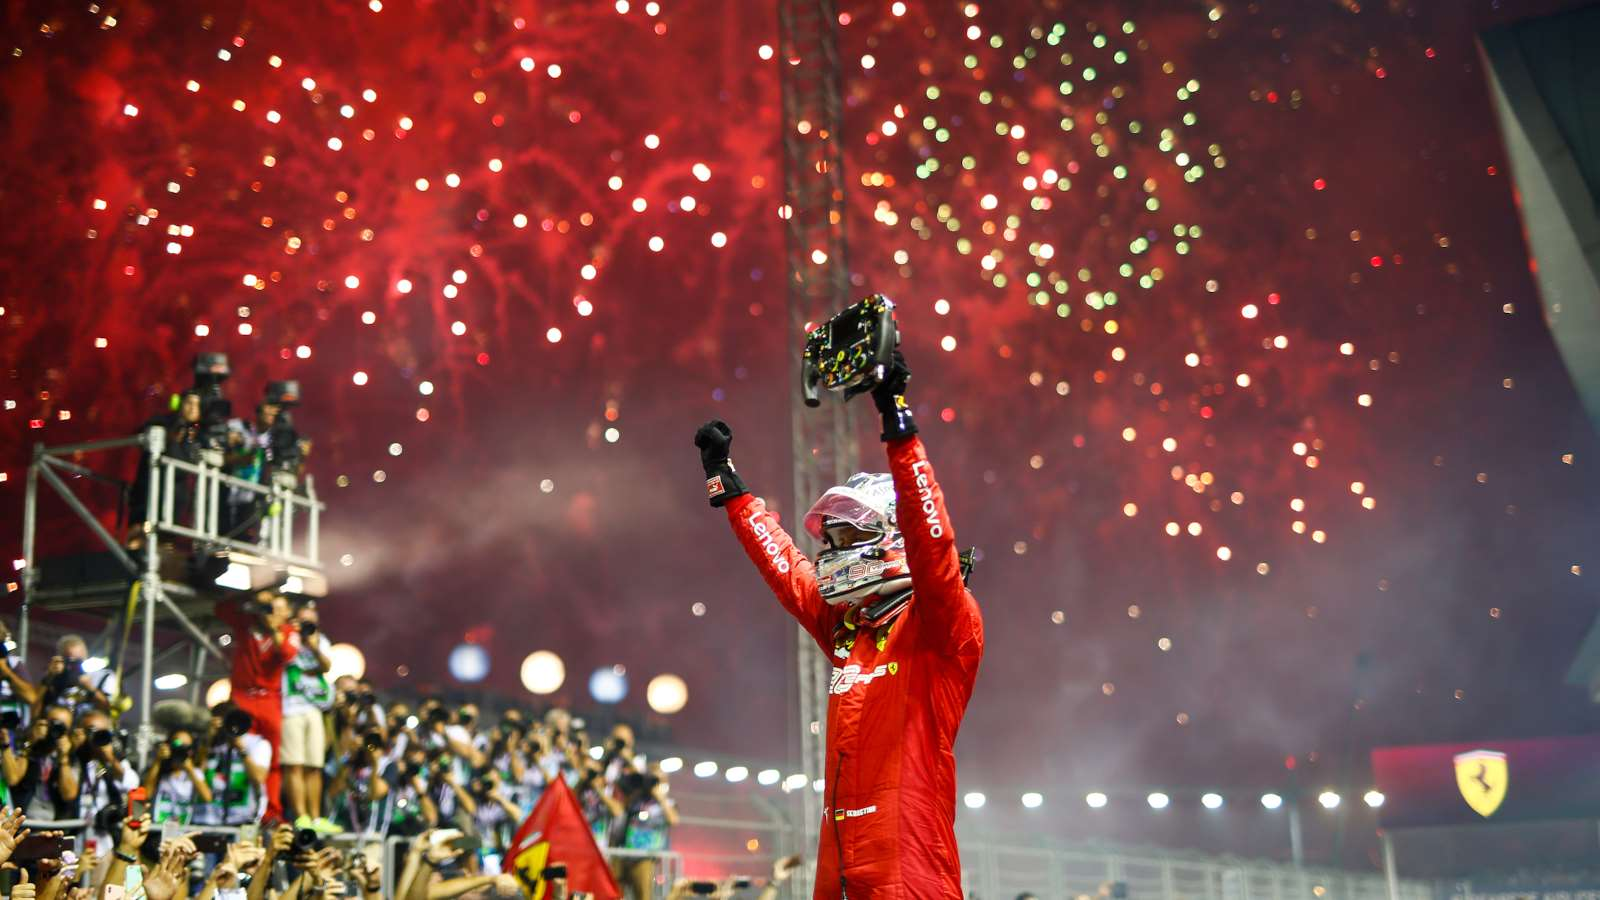


## 1. Prédiction de la position  à l'arrivée d'un pilote

On importe les librairies utiles pour ce projet.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from mpl_toolkits import mplot3d #Graphique 3D
from mpl_toolkits.mplot3d import axes3d


warnings.filterwarnings("ignore") #On n'affiche pas les avertissements
sns.set()
sns.set_style("white")


mpl.rcParams['figure.figsize'] = (12, 10)

On importe les datasets

In [ ]:
circuits = pd.read_csv("datasets/circuits.csv", index_col=0)
constructorResults = pd.read_csv("datasets/constructor_results.csv", index_col=0)
constructors = pd.read_csv("datasets/constructors.csv", index_col=0)
constructorStandings = pd.read_csv("datasets/constructor_standings.csv", index_col=0)
drivers = pd.read_csv("datasets/drivers.csv", index_col=0)
lapTimes = pd.read_csv("datasets/lap_times.csv")
pitStops = pd.read_csv("datasets/pit_stops.csv")
qualifying = pd.read_csv("datasets/qualifying.csv", index_col=0)
races = pd.read_csv("datasets/races.csv",index_col=0)
results = pd.read_csv("datasets/results.csv", index_col=0)
status = pd.read_csv("datasets/status.csv", index_col=0)
races = races.reindex(np.random.permutation(races.index))

Ici, nous allons supprimer les colonnes qui ne nous intéressent pas et qui prennent une place inutile à l'affichage.<br>

In [ ]:
drivers = drivers.drop(columns='url')
circuits = circuits.drop(columns=['alt','url','lat','lng','location'])
constructorResults = constructorResults.drop(columns='status')
constructors = constructors.drop(columns=['url'])
races = races.drop(columns=['url','time'])
# races.index.name = 'raceId'

On choisit uniquement les colonnes utiles pour la prédiction

In [ ]:
data = results[["raceId","driverId","constructorId","grid","position","statusId"]]
data.head()

Le dataset ne nous fournit pas la puissance de la voiture, cette donnée n'étant pas quantifiable (mis à part peut-être la puissance du moteur). Nous devons donc essayer nous-même de quantifier ce paramètre.

Dans le paddock, les deux ou trois écuries dominatrices arrivent à réaliser des tours souvent plus d'une seconde plus rapide que les écuries de milieu de plateau et les <i>backmarkers</i> : on cherche donc un coefficient $\mu_x$ permettant de modéliser cette disparité. Nous choisirons $\mu_x = \frac{1}{tan(0.1x)^{0.7}}$, avec $x$ la position au championnat constructeurs de l'année précédente nous appellerons cette feature **"constructorPower"**.

Bien entendu, les avancées technologiques d'une écurie ne se conservent pas toujours d'une année sur l'autre : un exemple flagrant en est l'écurie Brawn GP, victorieuse en 2009 grâce à un système à la légalité douteuse mais seulement 4e en 2010, sous l'égide de son acquéreur Mercedes. Ainsi, on utilise un deuxième coefficient, que nous appellerons coefficient de forme **"constructorForm"**, qui reprend l'équation du coefficient de puissance en remplacant $x$ par la position actuelle au championnat constructeur : ce coefficient progresse donc au fur et à mesure de la saison.

In [ ]:
# pour calculer "constructorForm " 
constructorStandings['constructorForm']  = pd.Series(constructorStandings["position"].apply(lambda x: 1.0/np.power(np.tan(0.1*x),0.7)))
constructorinfo = constructorStandings.drop(['points','position','positionText','wins'],axis=1)


In [ ]:
data = pd.merge(data,constructorinfo,on=['raceId','constructorId'])
data.head()

calculer **constructorPower** : 

In [ ]:
# pour calculer le classment de chaque equipe a lafin de la saison 

merged = constructorStandings.merge(races,right_index=True,left_on='raceId')
endOfYearPOS = merged.loc[merged.groupby(['year',"constructorId"])['round'].idxmax(),["position","constructorId","year"]]
endOfYearPOS.rename(columns={'position':'endYearPos'},inplace=True)
merged2  = pd.merge(merged,endOfYearPOS,on=['year',"constructorId"])
merged2.drop(['position','positionText','circuitId','wins','round','name','date'],axis=1,inplace=True)

merged2

In [ ]:
# pour avoir le classment final de l'an dernier de chaque equipe 
#%%time
c = merged2.copy()
def lastyearPOS(x):
    try:
        x.endYearPos = c['endYearPos'][c['constructorId']==x.constructorId][c['year']==(x.year-1)].tolist()[0]  
        return x  
    except Exception:
        x.endYearPos=5
        return x
merged2 = merged2.apply(lastyearPOS,axis=1)
del c
print("fini")

In [ ]:
merged2['constructorPower'] = merged2["endYearPos"].apply(lambda x: 1.0/np.power(np.tan(0.1*x),0.7))

In [ ]:
merged2.drop(['constructorForm','endYearPos','points'],axis=1,inplace=True)

In [ ]:
#merged2[merged2['constructorId']==1][merged2['year']==2019]
data = data.merge(merged2,on=['raceId','constructorId'])
data.rename(columns={'position':'positionOrder','constructorpower':'constructorPower'},inplace=True)
data.head()


la performance d'un pilote est une données trés importante pour bien réussir la prediction.sur les dataset qu'on a , on trouve pas cette information directement mais on peut l'extraire à partir des donnés qu'on a : <br>
Pour un pilote $i$, on crée le coefficient de performance $\mu_i$ de la manière suivante : $\mu_i = 1,1^{((x_j - x_i) + (r_j - r_i))}$ avec
- $x_i$ la position moyenne de qualifications du pilote
- $x_j$ la position moyenne de qualifications de son équipier
- $r_i$ le résultat de course moyen du pilote
- $r_j$ le résultat de course moyen de son équipier


In [ ]:
def getTeammate(raceId,driverId):
    result = results[results['raceId'] == raceId]
    constructor = result[result['driverId'] == driverId]['constructorId'].iloc[0]
    current_round = races['round'].loc[raceId]
    try:
        teammate = result[(results['constructorId'] == constructor) & (results['driverId'] != driverId)]['driverId'].iloc[0]
    except Exception:
        if current_round > 1: #Si ce n'est pas la première course de la saison, on retourne l'équipier de la course précédente
            return getTeammate(raceId-1, driverId)
        else:
            return getTeammate(raceId+1, driverId)
    return teammate
    
def getAverageQualifyingPosition(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : Le résultat moyen en qualifications pour cette saison (float)
    '''
    year = races['year'].loc[raceId]
    current_round = races['round'].loc[raceId]
    quali = 0
    nbMissing = 0
    for i in range(1,current_round+1):
        myrace = races[(races['year'] == year) & (races['round'] == i)].index[0]
        try:
            quali += qualifying[(qualifying['raceId'] == myrace) & (qualifying['driverId'] == driverId)]['position'].iloc[0]
        except Exception: #Si un pilote n'a pas participé à une séance de qualifications
            nbMissing +=1
    quali /= 1.0*(current_round-nbMissing)
    return quali

def getAverageFinalPosition(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : Le résultat moyen en course pour cette saison (float)
    '''
    year = races['year'].loc[raceId]
    current_round = races['round'].loc[raceId]
    pos = 0
    nbMissing = 0
    for i in range(1,current_round+1):
        try:
            myrace = races[(races['year'] == year) & (races['round'] == i)].index[0]
            #print("{}, {}\r".format(myrace, driverId)),
            pos += results[(results['raceId'] == myrace) & (results['driverId'] == driverId)]['positionOrder'].iloc[0]
        except Exception:
            nbMissing +=1
    pos /= 1.0*(current_round-nbMissing)
    return pos


In [ ]:
def computeDriverPerformance(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : Le coefficient de performance du pilote pour la saison en cours (float)
    '''
    try : 
        print("Id du pilote : {}, Id de la course : {} \r".format(driverId, raceId)),
        teammate = getTeammate(raceId, driverId)
        avg_quali_pos = getAverageQualifyingPosition(raceId, driverId)
        teammate_quali_pos = getAverageQualifyingPosition(raceId, teammate)
        avg_final_pos = getAverageFinalPosition(raceId, driverId)
        teammate_final_pos = getAverageFinalPosition(raceId, teammate)
        #quali_h2h = getQualiHeadToHead(raceId,driverId)
        #race_h2h = getRaceHeadToHead(raceId,driverId)
        coefficient = (teammate_quali_pos-avg_quali_pos) + (teammate_final_pos-avg_final_pos)
#         coefficient = np.power(1.1,coefficient)
        coefficient = 1./(1+np.exp(-coefficient))
    except Exception:
       return 1.0 # on cas où un pilote n'as pas de teammate ou n'as pas participé au qualification on lui donne la valeur de la median de ce coefficient
    return coefficient

In [ ]:
test = data.iloc[0:50]
test['driverPerformance'] = test.apply(lambda x: computeDriverPerformance(x['raceId'], x['driverId']), axis=1)
sns.kdeplot(test['driverPerformance'], shade=True)

In [ ]:
# calcul de driverPerformance
%time data['driverPerformance'] = results.apply(lambda x: computeDriverPerformance(x['raceId'], x['driverId']), axis=1) 


In [ ]:
data.to_csv('final_dataset_2.csv')
data.describe()

In [ ]:
mydata = pd.read_csv('final_dataset_2.csv')
res_cropped = results[['raceId', 'driverId', 'positionOrder']]
mydata = mydata.merge(res_cropped, on=['raceId', 'driverId'])
display(mydata.head(10))
display(mydata.describe())

In [ ]:
##### # my_dataset = pd.read_csv('final_dataset_2.csv')
my_dataset = mydata
#my_dataset.describe()
'''
On garde uniquement les pilotes qui ont terminé la course
Status 1 : fini la course
Status 11 : +1 Lap
Status 12 : +2 Laps
'''
my_dataset = my_dataset[(my_dataset['statusId'] == 1) | (my_dataset['statusId'] == 11) | (my_dataset['statusId'] == 12)]
# my_dataset["positionOrder"] = my_dataset["positionOrder"].astype('int64')
my_dataset["driverPerformance"] = my_dataset['driverPerformance'].apply(lambda x: -np.log((1./x) - 1))
#On garde uniquement les colonnes qui nous intéressent.
my_dataset = my_dataset[['grid','positionOrder','constructorForm','driverPerformance']]
#On mélange le dataset
my_dataset = my_dataset.reindex(np.random.permutation(my_dataset.index))
my_dataset = my_dataset.dropna()
my_dataset = my_dataset[(np.abs(my_dataset['driverPerformance']) < 10)]
my_dataset.describe()

Traçons quelques graphiques pour visualiser la distribution de nos données.

- Sur le premier graphique, on voit qu'il y a une très forte corrélation entre la position sur la grille et la position à l'arrivée.

- Sur les deuxième et troisième graphes, on remarque la corrélation entre les coefficients de puissance et de forme et la position à l'arrivée.

In [ ]:
sns.kdeplot(my_dataset['driverPerformance'], shade=True)

In [ ]:
sns.pairplot(my_dataset, hue="positionOrder", palette='cool');

In [ ]:
sns.jointplot(my_dataset['grid'],my_dataset['positionOrder'],
              kind='kde')
plt.suptitle("Position a l'arrivee en fonction de la position de depart")

# sns.jointplot(my_dataset['constructorPower'],my_dataset['positionOrder'],
#               kind='hex')
# plt.suptitle("Position a l'arrivee en fonction de la position au championnat n-1")

sns.jointplot(my_dataset['constructorForm'],my_dataset['positionOrder'],
              kind='hex')
plt.suptitle("Position a l'arrivee en fonction de la position au championnat")
sns.jointplot(my_dataset['driverPerformance'],my_dataset['positionOrder'], kind='hex')
plt.suptitle("Position a l'arrivee en fonction de la performance du pilote")

In [ ]:
#matplotlib notebook pour faire tourner le graphique
%matplotlib inline
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111, projection='3d')
# Data for three-dimensional scattered points
zdata1 = my_dataset['positionOrder']
xdata1 = my_dataset['driverPerformance']
ydata1 = my_dataset['grid']
ax1.scatter3D(xdata1, ydata1, zdata1, c=(zdata1), cmap='cool');
ax1.set_xlabel('constructorForm')
ax1.set_ylabel('grid position')
ax1.set_zlabel('final position')
fig.show()

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(my_dataset['driverPerformance'],my_dataset['positionOrder'], cmap=cmap, n_levels=100, shade=True);

In [ ]:
#Afin d'être sûrs, on retire les valeurs nulles
my_dataset = my_dataset.dropna()

#On crée les ensembles d'entraînement et de test.
train_dataset = my_dataset.sample(frac=0.8,random_state=1)
test_dataset = my_dataset.drop(train_dataset.index)

#C'est une manière de récupérer la moyenne et l'écart-type de chaque colonne.
train_stats = train_dataset.describe()
train_stats.pop("positionOrder")
train_stats = train_stats.transpose()

train_labels = train_dataset.pop('positionOrder')
test_labels = test_dataset.pop('positionOrder')

def stand(x): # fonction pour standaridiser les données
  return (x - train_stats['mean']) / train_stats['std']
std_train_data = stand(train_dataset)
std_test_data = stand(test_dataset)

display(std_test_data.head(20))

### Création d'un réseau de neurone avec TensorFlow

Typiquement, TensorFlow permet d'obtenir une bonne précision sur les résultats si on sait ce qu'on fait.
Nous allons créer et entraîner ce réseau de neurone avec TensorFlow puis comparer ses prédictions avec notre modèle lineaire.

In [ ]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_model()

In [ ]:
EPOCHS = 100

history = model.fit(
  std_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)
test_predictions = model.predict(std_test_data).flatten()


In [ ]:
sns.jointplot(test_labels, test_predictions, kind='hex')
plt.suptitle('Valeurs predites par TensorFlow contre vraies valeurs')

In [ ]:
rmse_TF  = np.sqrt(np.square(test_predictions - test_labels).mean())
print('la RMSE de ce modèle est : {}'.format(rmse_TF))
TFError = test_predictions - test_labels
fig, ax = plt.subplots(1,1)
plt.hist(TFError, bins = 20, color='gold',alpha=0.9)
ax.set_facecolor('xkcd:dark grey')
ax.grid(False)

plt.xlabel("Erreur sur la prediction avec TensorFlow")
_ = plt.ylabel("Nombre")

Qu'observe-t-on ? On voit que la prédiction a fonctionné, l'algorithme arrive à trouver la position du pilote.

### Création du modèle lineaire

Ici, nous allons coder à la main un modèle de regression lineaire optimisé avec un algorithme de descente de gradient 
 pour prédire la position à l'arrivée d'un pilote.
L'objectif est de pouvoir faire tourner l'algorithme plus rapidement que Lance Stroll.

In [ ]:
from LinearModel import LinearModel  
# le code de LinearModel est dans le fichier LinearModel.py
hist = [] # loss pour chaque iteration
train = train_dataset.to_numpy()
lab = train_labels.to_numpy()
test = test_dataset.to_numpy()
test_lab = test_labels.to_numpy()
print(train.shape[1])

LM = LinearModel('RMSE')
hist= LM.build_model(train,lab,200)
predicted_labels = LM.predict(test)



In [ ]:
from new_linear_model import NewLinearModel
train = train_dataset.to_numpy()
lab = train_labels.to_numpy()
test = test_dataset.to_numpy()
test_lab = test_labels.to_numpy()
LM = NewLinearModel('RMSE')
hist = LM.build_model(data=train,labels=lab,method='direct',Niter=200)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax3 = fig.add_subplot(111)
l1, = ax3.plot(np.arange(len(hist)), hist, 'red')
plt.suptitle('Evolution de la RMSE en fonction des iterations')
plt.yscale('log')


In [ ]:
myplot = sns.jointplot(predicted_labels, test_lab,kind='hex')
plt.suptitle("Valeurs predites contre vraies valeurs")

In [ ]:
print('la RMSE de ce modèle est : {}'.format(hist[-1]))
error = (predicted_labels - test_lab)
sns.distplot(error)
# fig, ax = plt.subplots(1,1)
# plt.hist(error, bins = 20, color='gold',alpha=0.9)
# ax.set_facecolor('xkcd:dark grey')
# ax.grid(False)
# plt.xlabel("Erreur sur la prediction")
# _ = plt.ylabel("Nombre")

In [ ]:
print('La RMSE de la régression linéaire est {:.2f}'.format(hist[-1]))
print('La RMSE du réseau de neurones est {:.2f}'.format(rmse_TF))

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(TFError, shade=True)
sns.kdeplot(error, shade=True)
ax.set_facecolor('xkcd:dark grey')
ax.grid(False)

In [ ]:
fig = plt.figure(figsize=(14,5),dpi=300)
ax2 = fig.add_subplot(121)
ax2.hist(error, bins = 20, color='blue',alpha=0.5)
ax2.set_ylabel('Nombre de predictions')
ax2.set_xlabel(u'Erreur (en nombre de positions)')
ax2.set_facecolor('xkcd:white')
plt.xlim(0,10)
ax2.legend()
ax2.grid(False)
ax2.title.set_text('regression lineaire')
     
ax1 = fig.add_subplot(122)
ax1.hist(TFError, bins = 20, color='red',alpha=0.5)
ax1.title.set_text('reseau de noronnes avec TF')
ax1.set_facecolor('xkcd:white')
plt.xlim(0,10)
ax1.set_xlabel(u'Erreur (en nombre de positions)')
ax1.grid(False)
plt.tight_layout()

On peut remarquer que la regression lineaire ne présente pas d'overfitting et prédit plutôt bien la position d'arrivée du pilote, même si le reseau de norones est légèrement plus performant.